# **IgFold**: Fast, accurate antibody structure prediction

Official notebook for [IgFold](https://www.biorxiv.org/content/10.1101/2022.04.20.488972): Fast, accurate antibody structure prediction from deep learning on massive set of natural antibodies.  The code, data, and weights for this work are made available for non-commercial use. For commercial inquiries, please contact `jruffolo[at]jhu.edu`.

##Installation in Colab/ Jupyter Notebook/ Dependency Installation

In [1]:
# 1. Uninstall and clean up potentially conflicting core packages
print("1. Uninstalling old torch and core dependencies...")
!pip uninstall torch torchvision torchaudio transformers numpy -y

# 2. Installing modern PyTorch...
!pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu118

# 3. Install IgFold/ dependencies
print("3. Installing IgFold and base dependencies...")
!pip install igfold --upgrade

# 4. Installing visualization (py3Dmol) and ensuring core versions...
print("4. Installing visualization (py3Dmol) and ensuring core versions...")
!pip install py3Dmol
!pip install transformers --upgrade

# 5. Installing OpenMM refinement dependencies (pdbfixer, openmm) using Conda...
print("5. Installing OpenMM refinement dependencies (pdbfixer, openmm) using Conda...")

# Install condacolab (to use conda/mamba in Google Colab)
!pip install -q condacolab

# Restart session to finalize condacolab setup
import condacolab
condacolab.install()

# Use mamba to install the scientific packages from the trusted conda-forge channel
# Crucially, we remove the explicit Python version pinning that caused the conflict
!mamba install -c conda-forge openmm pdbfixer -y

print("OpenMM and PDBFixer installation complete.")

# 6. Install missing dependency for antibody renumbering (abnumber)
print("6. Installing abnumber...")
!pip install abnumber


print("\nInstallation complete. Please RESTART THE SESSION now (Runtime -> Restart session).")

1. Uninstalling old torch and core dependencies...
Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Successfully uninstalled torchvision-0.23.0+cu126
Found existing installation: torchaudio 2.8.0+cu126
Uninstalling torchaudio-2.8.0+cu126:
  Successfully uninstalled torchaudio-2.8.0+cu126
Found existing installation: transformers 4.57.1
Uninstalling transformers-4.57.1:
  Successfully uninstalled transformers-4.57.1
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Looking in indexes: https://download.pytorch.org/whl/cu118
ERROR: Could not find a version that satisfies the requirement torch==2.1.0 (from versions: 2.2.0+cu118, 2.2.1+cu118, 2.2.2+cu118, 2.3.0+cu118, 2.3.1+cu118, 2.4.0+cu118, 2.4.1+cu118, 2.5.0+cu118, 2.5.1+cu118, 2.6.0+cu118, 2.7.0+cu118, 2.7.1+cu118

4. Installing visualization (py3Dmol) and ensuring core versions...
5. Installing OpenMM refinement dependencies (pdbfixer, openmm) using Conda...
⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:11
🔁 Restarting kernel...

Looking for: ['openmm', 'pdbfixer']

[+] 0.0s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.1s
conda-forge/linux-64   1%
conda-forge/noarch    ⣾  [+] 0.2s
conda-forge/linux-64   8%
conda-forge/noarch    20%[+] 0.3s
conda-forge/linux-64  17%
conda-forge/noarch    40%[+] 0.4s
conda-forge/linux-64  24%
conda-forge/noarch    53%[+] 0.5s
conda-forge/linux-64  26%
conda-forge/noarch    64%[+] 0.6s
conda-forge/linux-64  33%
conda-forge/noarch    71%[+] 0.7s
conda-forge/linux-64  39%
conda-forge/noarch    87%conda-forge/noarch                                
[+] 0.8s
conda-forge/linux-64  46%


Installation complete. Please RESTART THE SESSION now (Runtime -> Restart session).


##Reload imports/definitions cell

In [1]:
# Initialization process / prepare environment
import os
import torch
import torch.serialization
from igfold import IgFoldRunner
import py3Dmol

# Imports for model deserialization (required by IgFold's loading mechanism)
from transformers.models.bert.configuration_bert import BertConfig
from transformers.models.bert.tokenization_bert import BertTokenizer
from transformers.tokenization_utils import Trie
from transformers.models.bert.tokenization_bert import BasicTokenizer
from transformers.models.bert.tokenization_bert import WordpieceTokenizer

# Core IgFold utility import (note: show_pdb is an optional viz function)
from igfold.utils.visualize import show_pdb

# 1. Setup/ configuration
# Define sequences
SEQUENCES = {
    "H": "QVQLQESGPGLVKPSQTLSLTCAISGDSVSSNSAAWNWIRQSPSRGLEWLGRTYYRSKWYNDYAVSVRRFTISRDDSKNTVYLQMNSLRAEDTAVYYCARYYYYYYGMDYWGQGSLVTVSS",
    "L": "DIQMTQSPSSLSASVGDRVTITCKASQSVSANDVVAWYQQKPGKAPKLVIYWASTRESGVPSRFSGSGSGTDFTLTISSLQPEDFATYYCLQHFWSTPRTFGQGTKVEIK"
}

# Define output path and file name
ANTIBODY_NAME = "chimeric_anti-OKT3_scFv"
PRED_DIR = "igfold_predictions"
DO_REFINE = False
DO_RENUM = False
USE_OPENMM = False
NUM_MODELS = 4

# Create output directory/ file path (must run once)
if not os.path.exists(PRED_DIR):
    os.makedirs(PRED_DIR)
pred_pdb_path = os.path.join(PRED_DIR, f"{ANTIBODY_NAME}.pdb")

# 2. Folding execution
if __name__ == "__main__":
    # Load IgFold models using the patched safe_globals context manager
    with torch.serialization.safe_globals({BertConfig, BertTokenizer, Trie, BasicTokenizer, WordpieceTokenizer}):
        print(f"Initializing IgFoldRunner with {NUM_MODELS} models...")
        igfold = IgFoldRunner(num_models=NUM_MODELS)
        print("Successfully loaded IgFold and AntiBERTy models.")

    # Perform folding prediction
    print(f"\nFolding sequences for {ANTIBODY_NAME}...")

    igfold.fold(
        pred_pdb_path,
        sequences=SEQUENCES,
        do_refine=DO_REFINE,
        use_openmm=USE_OPENMM,
        do_renum=DO_RENUM,
    )

    print(f"Structure successfully saved to {pred_pdb_path}")

    # Display final structure using igfold's utility
    show_pdb(
        pred_pdb_path,
        len(SEQUENCES),
        bb_sticks=False,
        sc_sticks=True,
        color="rainbow"
    )

# 3. Visualization with py3Dmol (Use PRED_DIR and ANTIBODY_NAME for consistency)
# This code runs *outside* the if __name__ == "__main__": block
pdb_file = os.path.join(PRED_DIR, f"{ANTIBODY_NAME}.pdb")

# Create and display the py3Dmol view
view = py3Dmol.view(query=f'pdb:{pdb_file}', width=800, height=600)
view.setStyle({'cartoon': {'color': 'spectrum'}})
view.zoomTo()
view.show()

/usr/local/lib/python3.12/dist-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Initializing IgFoldRunner with 4 models...

    The code, data, and weights for this work are made available for non-commercial use 
    (including at commercial entities) under the terms of the JHU Academic Software License 
    Agreement. For commercial inquiries, please contact awichma2[at]jhu.edu.
    License: https://github.com/Graylab/IgFold/blob/main/LICENSE.md
    
Loading 4 IgFold models...
Using device: cpu
Loading /usr/local/lib/python3.12/dist-packages/igfold/trained_models/IgFold/igfold_1.ckpt...
Loading /usr/local/lib/python3.12/dist-packages/igfold/trained_models/IgFold/igfold_2.ckpt...
Loading /usr/local/lib/python3.12/dist-packages/igfold/trained_models/IgFold/igfold_3.ckpt...
Loading /usr/local/lib/python3.12/dist-packages/igfold/trained_models/IgFold/igfold_5.ckpt...
Successfully loaded 4 IgFold models.


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Loaded AntiBERTy model.
Successfully loaded IgFold and AntiBERTy models.

Folding sequences for chimeric_anti-OKT3_scFv...


/usr/local/lib/python3.12/dist-packages/igfold/utils/coordinates.py:18: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /pytorch/aten/src/ATen/native/Cross.cpp:63.)
  n_vec = (b_coord - a_coord).expand(bc_vec.shape).cross(bc_vec)
/usr/local/lib/python3.12/dist-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Tr

Completed folding in 42.93 seconds.
Structure successfully saved to igfold_predictions/chimeric_anti-OKT3_scFv.pdb


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

##Structural Prediction of chimeric_anti_OKT3_scFv

In [5]:
# 1. Imports/ set-up
import os
import torch
import torch.serialization
from igfold import IgFoldRunner
from igfold.utils.visualize import show_pdb

# Imports for model deserialization
from transformers.models.bert.configuration_bert import BertConfig
from transformers.models.bert.tokenization_bert import BertTokenizer
from transformers.tokenization_utils import Trie
from transformers.models.bert.tokenization_bert import BasicTokenizer
from transformers.models.bert.tokenization_bert import WordpieceTokenizer

# 2. Configuration/ preparation

# Define sequences
SEQUENCES = {
    "H": "QVQLQESGPGLVKPSQTLSLTCAISGDSVSSNSAAWNWIRQSPSRGLEWLGRTYYRSKWYNDYAVSVRRFTISRDDSKNTVYLQMNSLRAEDTAVYYCARYYYYYYGMDYWGQGSLVTVSS",
    "L": "DIQMTQSPSSLSASVGDRVTITCKASQSVSANDVVAWYQQKPGKAPKLVIYWASTRESGVPSRFSGSGSGTDFTLTISSLQPEDFATYYCLQHFWSTPRTFGQGTKVEIK"
}

# Define output path/ file name
ANTIBODY_NAME = "chimeric_anti-OKT3_scFv"
PRED_DIR = "igfold_predictions"

# Execution flags
DO_REFINE = False
DO_RENUM = False
USE_OPENMM = False
NUM_MODELS = 4

# Create output directory and file path
if not os.path.exists(PRED_DIR):
    os.makedirs(PRED_DIR)
pred_pdb_path = os.path.join(PRED_DIR, f"{ANTIBODY_NAME}.pdb")

# 3. Execution/ visualization

# Load IgFold models using patched safe_globals context manager
with torch.serialization.safe_globals({BertConfig, BertTokenizer, Trie, BasicTokenizer, WordpieceTokenizer}):
    print(f"Initializing IgFoldRunner with {NUM_MODELS} models...")
    igfold = IgFoldRunner(num_models=NUM_MODELS)
    print("Successfully loaded IgFold and AntiBERTy models.")

# Perform folding prediction
print(f"\nFolding sequences for {ANTIBODY_NAME}...")

# Assign output to 'pred' for later analysis cells
pred = igfold.fold(
    pred_pdb_path,
    sequences=SEQUENCES,
    do_refine=DO_REFINE,
    use_openmm=USE_OPENMM,
    do_renum=DO_RENUM,
)

print(f"Structure successfully saved to {pred_pdb_path}")

# Display final structure
print("\nRendering 3D Structure:")
show_pdb(
    pred_pdb_path,
    len(SEQUENCES),
    bb_sticks=False,
    sc_sticks=True,
    color="rainbow"
)


Initializing IgFoldRunner with 4 models...

    The code, data, and weights for this work are made available for non-commercial use 
    (including at commercial entities) under the terms of the JHU Academic Software License 
    Agreement. For commercial inquiries, please contact awichma2[at]jhu.edu.
    License: https://github.com/Graylab/IgFold/blob/main/LICENSE.md
    
Loading 4 IgFold models...
Using device: cpu
Loading /usr/local/lib/python3.12/dist-packages/igfold/trained_models/IgFold/igfold_1.ckpt...
Loading /usr/local/lib/python3.12/dist-packages/igfold/trained_models/IgFold/igfold_2.ckpt...
Loading /usr/local/lib/python3.12/dist-packages/igfold/trained_models/IgFold/igfold_3.ckpt...
Loading /usr/local/lib/python3.12/dist-packages/igfold/trained_models/IgFold/igfold_5.ckpt...
Successfully loaded 4 IgFold models.
Loaded AntiBERTy model.
Successfully loaded IgFold and AntiBERTy models.

Folding sequences for chimeric_anti-OKT3_scFv...


/usr/local/lib/python3.12/dist-packages/igfold/model/components/IPABlock.py:160: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with disable_tf32(), autocast(enabled = False):


Completed folding in 43.25 seconds.
Structure successfully saved to igfold_predictions/chimeric_anti-OKT3_scFv.pdb

Rendering 3D Structure:


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Predicted RMSD plot saved to igfold_predictions/chimeric_anti-OKT3_scFv_prmsd.png


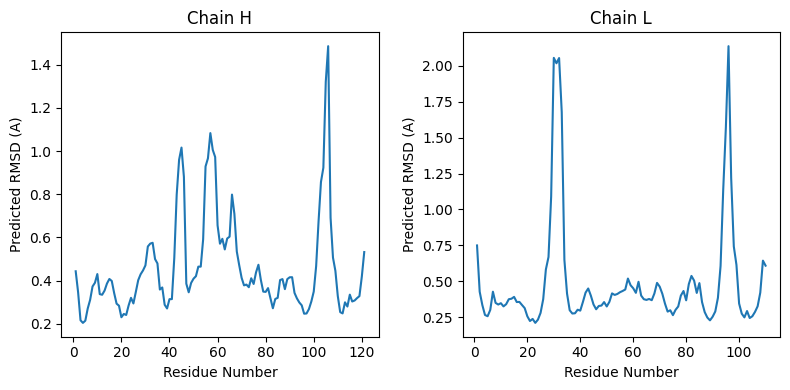

In [8]:
# Define the prediction directory name (IgFold default)
# pred_dir = "igfold_predictions" <-- Already defined in the main block
# Define the name of your sequence (as used in the prediction step)
# name = "chimeric_anti-OKT3_scFv" <-- Already defined as ANTIBODY_NAME in the main block

prmsd_fig_file = os.path.join(PRED_DIR, f"{ANTIBODY_NAME}_prmsd.png")

# CRITICAL: Use ANTIBODY_NAME and PRED_DIR from the main script
plot_prmsd(SEQUENCES, pred.prmsd.cpu(), prmsd_fig_file, shade_cdr=DO_RENUM, pdb_file=pred_pdb_path)
print(f"Predicted RMSD plot saved to {prmsd_fig_file}")


In [10]:
#@title Show predicted structure with predicted RMSD

#@markdown Structure is colored from low (blue) to high (red) pRMSD.

# FIX: Change 'pred_pdb' to 'pred_pdb_path' to match the main script
show_pdb(pred_pdb_path, len(SEQUENCES), bb_sticks=False, sc_sticks=True, color="b")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [11]:
#@title Download results

#@markdown Download zip file containing structure prediction and annotation results. If download fails, results are also accessible from file explorer on the left panel of the notebook.

from google.colab import files
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!zip -FSr $name".result.zip" $pred_dir/ &> /dev/null
files.download(f"{name}.result.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>